# NLP Text Classification with TensorFlow using an LSTM
* Notebook by Adam Lang
* Date: 7/12/2024

# Overview
* We will perform text classification using TensorFlow.
* We are going to use NLP to analyze tweets and determine if it is classified as a "disaster event" or not.
* We will use an LSTM.

## Imports

In [9]:
## tf imports
import tensorflow as tf
from tensorflow import keras

## other imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

## Dataset Import
* We will import the data from github.
* The dataset is the disaster tweets dataset from kaggle: https://www.kaggle.com/competitions/nlp-getting-started

In [2]:
import requests # make API request to data source
#import zipfile # if your data is in zip file
from pathlib import Path # create file/directory

# setup path to data folder
data_path = Path("data/")
train_path = data_path / "disaster_tweets"


# if the folder doesn't exist, download it and prepare it
if train_path.is_dir():
  print(f"{train_path} directory already exists...skipping download")
else:
  print(f"{train_path} does not exist, creating one...")
  train_path.mkdir(parents=True, exist_ok=True)

# Download file
with open(data_path / "train.csv", "wb") as f:
  ## raw request from github
  request = requests.get('https://raw.githubusercontent.com/nikjohn7/Disaster-Tweets-Kaggle/main/data/train.csv')
  print("Downloading data....")
  f.write(request.content) # write content of request to a file

# print data_path
data_path

data/disaster_tweets directory already exists...skipping download


PosixPath('data')

In [3]:
# new data path
new_path = '/content/data/train.csv'

In [4]:
## upload data
df = pd.read_csv(new_path)

In [5]:
## head df
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
## shape
df.shape

(7613, 5)

In [7]:
## info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
## target class analysis
print(f"Disaster tweets target size: {(df.target == 1).sum()}")
print(f"No disaster tweets target size: {(df.target == 0).sum()}")

Disaster tweets target size: 3271
No disaster tweets target size: 4342


In [11]:
## check for null values
df.isnull().sum().sort_values(ascending=False)

location    2533
keyword       61
id             0
text           0
target         0
dtype: int64

Summary:
* The targe variable has no null values, we know the keyword and location columns have null values but we don't need those for this project.

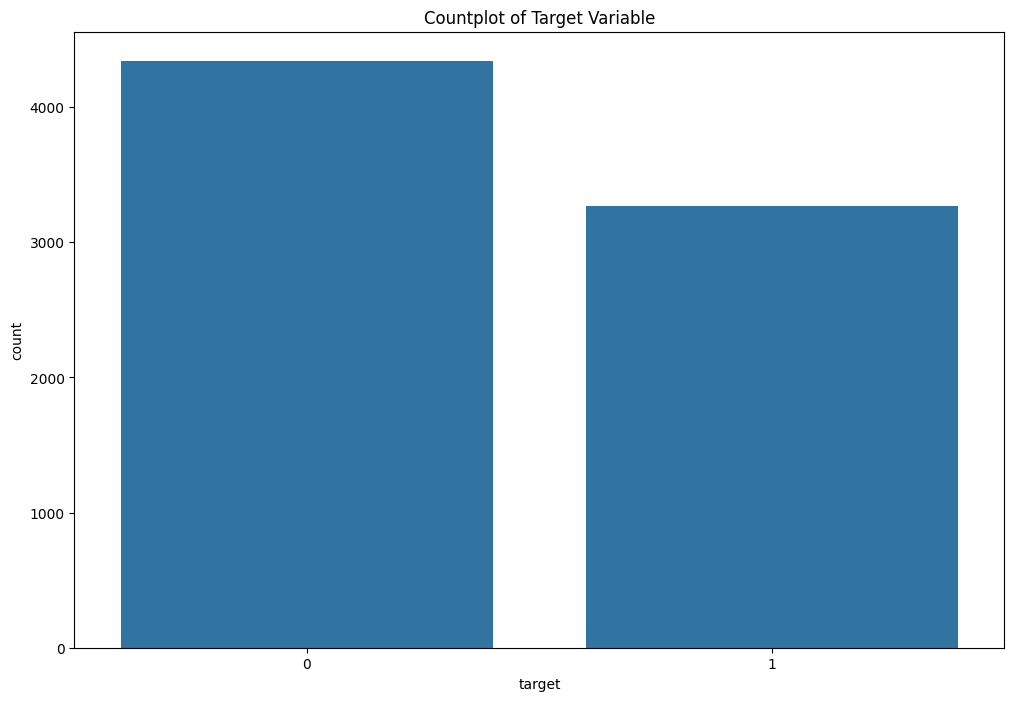

In [13]:
## count plot of target variables
plt.figure(figsize=(12,8))
sns.countplot(x='target',data=df).set(title="Countplot of Target Variable")
plt.show();

Summary:
* The target variable is not significantly imbalanced so we don't need to downsample or upsample. If we did we could use random sampling with replacement or SMOTE (to name a few).

## Text Pre-processing

### URLs and Punctuation

In [16]:
## sample of text column
import random
import re
import string


# helper function to remove urls
def remove_URL(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

# helper function to remove punctuation
def remove_punct(text):
  translator = str.maketrans("", "", string.punctuation)
  return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

These are all the punctuation chars to remove.

In [17]:
## testing functions
pattern = re.compile(r"https?://\S+|www\.\S+")
for t in df.text:
  matches = pattern.findall(t)
  for m in matches:
    print(t)
    print(m)
    print(pattern.sub(r"", t))
  if len(matches) > 0:
    break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
http://t.co/lHYXEOHY6C
@bbcmtd Wholesale Markets ablaze 


In [18]:
## apply functions to clean text of urls and punctuations
df['text'] = df.text.map(remove_URL)
df['text'] = df.text.map(remove_punct)

### Stopwords removal

In [19]:
# install nltk
!pip install nltk

In [20]:
## removing stopwords
import nltk
nltk.download('stopwords') #download stopwords from nltk
from nltk.corpus import stopwords #import stopwords

# instantiate stop words --> English
stop = set(stopwords.words('english'))

# helper function to remove stopwords
def remove_stopwords(text):
  filter_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filter_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
## print stop words
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [22]:
## how many stop words are there
print(len(stop))

179


In [23]:
## apply function to remove stopwords
df['text'] = df.text.map(remove_stopwords)

In [24]:
## sample the df
df['text'].sample(20)

4670    oh boots amp hearts social media inundation st...
2464    mumbai24x7 helping hand mumbai 2 ttes take cha...
6896    emily4everever haha alrightbut twice stupid he...
6733    high priority severe thunderstorm watch ended ...
86      fyi cadfyi accident property damagenhs999 pine...
3707                fear factory cars official musicvideo
6794    tragedy added wrong book tbr list cant find ri...
4898                remember massacre civilians hiroshima
3425    tagged attackonstiles millions apunk hang em h...
2399      heres may caused metro train derail downtown dc
2535    kaiseiw theres people like whole people named ...
3953                                             flooding
7081    look state actions year fergusonûªs upheaval ...
7564    ohhmyjoshh stevenrulles gonna thinking gets sh...
3585        police man early 30s dies shooting vermont st
5536    liked youtube video us canada radiation update...
1062                            bomb ass firework picture
6447    hajihu

In [52]:
len(df.text)

7613

In [53]:
## counting the words in each row in the text column
df['word_count'] = df['text'].str.split().map(len)

In [55]:
df['word_count'].value_counts()

word_count
11    773
9     722
8     707
10    704
12    647
13    626
7     608
6     585
5     449
14    411
4     343
15    290
3     246
16    155
2     139
17     93
1      38
18     38
19     22
20      8
21      4
25      2
22      1
24      1
23      1
Name: count, dtype: int64

In [32]:
## pre-process text for RNN model
## first we want to count unique words

from collections import Counter

count_dict = {}
# helper function to count unique words
def counter_word(text_col):
  count = Counter()
  # iterate over text
  for text in text_col.values:
    # split whitespace
    for word in text.split():
      # count
      count[word] += 1
  return count


# instantiate the counter
counter = counter_word(df.text)

In [33]:
## len counter
print(len(counter))

17971


In [34]:
counter

Counter({'deeds': 2,
         'reason': 20,
         'earthquake': 50,
         'may': 88,
         'allah': 9,
         'forgive': 2,
         'us': 164,
         'forest': 65,
         'fire': 250,
         'near': 54,
         'la': 25,
         'ronge': 1,
         'sask': 1,
         'canada': 11,
         'residents': 8,
         'asked': 9,
         'shelter': 6,
         'place': 26,
         'notified': 1,
         'officers': 8,
         'evacuation': 50,
         'orders': 11,
         'expected': 15,
         '13000': 4,
         'people': 196,
         'receive': 2,
         'wildfires': 11,
         'california': 117,
         'got': 112,
         'sent': 13,
         'photo': 41,
         'ruby': 1,
         'alaska': 6,
         'smoke': 48,
         'pours': 1,
         'school': 66,
         'rockyfire': 4,
         'update': 37,
         'hwy': 9,
         '20': 26,
         'closed': 20,
         'directions': 1,
         'due': 31,
         'lake': 14,
         'co

In [35]:
## most common words
print(counter.most_common(5))

[('like', 345), ('im', 299), ('amp', 298), ('fire', 250), ('get', 229)]


In [36]:
## count unique words
num_unique_words = len(counter)

In [37]:
num_unique_words

17971

## Feature Engineering
* Train test split

In [39]:
# split into train and validation sets
from sklearn.model_selection import train_test_split

In [76]:
## set up the train and test df
train_size = int(df.shape[0] * 0.8)

train_df = df[:train_size]
test_df = df[train_size:]

# split into labels and text
train_sents = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()
test_sents = test_df.text.to_numpy()
test_labels = test_df.target.to_numpy()

In [77]:
print(train_labels)

[1 1 1 ... 0 0 0]


In [78]:
## Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer


# vectorize text corpus by turning text into integer sequences
tokenizer = Tokenizer(num_words=num_unique_words)

# fit tokenizer
tokenizer.fit_on_texts(train_sents) # only fit training data

In [79]:
## instantiate word index
word_index = tokenizer.word_index

Tokenizer gives each word a unique index

In [80]:
## print word_index
word_index

{'like': 1,
 'amp': 2,
 'fire': 3,
 'im': 4,
 'get': 5,
 'via': 6,
 'new': 7,
 'people': 8,
 'news': 9,
 'dont': 10,
 'emergency': 11,
 'one': 12,
 '2': 13,
 'us': 14,
 'video': 15,
 'disaster': 16,
 'burning': 17,
 'body': 18,
 'would': 19,
 'buildings': 20,
 'police': 21,
 'crash': 22,
 'first': 23,
 'california': 24,
 'still': 25,
 'man': 26,
 'got': 27,
 'know': 28,
 'day': 29,
 'back': 30,
 'going': 31,
 'two': 32,
 'time': 33,
 'full': 34,
 'accident': 35,
 'see': 36,
 'world': 37,
 'attack': 38,
 'nuclear': 39,
 'youtube': 40,
 'may': 41,
 'love': 42,
 'go': 43,
 'rt': 44,
 'many': 45,
 'cant': 46,
 '3': 47,
 'watch': 48,
 'collapse': 49,
 'dead': 50,
 'today': 51,
 'car': 52,
 'mass': 53,
 'want': 54,
 'years': 55,
 'work': 56,
 'train': 57,
 'last': 58,
 'good': 59,
 'think': 60,
 'families': 61,
 'hiroshima': 62,
 'life': 63,
 'fires': 64,
 'best': 65,
 'could': 66,
 'say': 67,
 'u': 68,
 'death': 69,
 'hot': 70,
 'forest': 71,
 'way': 72,
 'killed': 73,
 'need': 74,
 'legion

In [81]:
## convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_sents)
test_sequences = tokenizer.texts_to_sequences(test_sents)

### Comparing sentences to encoded sequences

In [82]:
## compare sentences to the encoded sequences
print(train_sents[30:35])
print(train_sequences[30:35])

['end' 'bbcmtd wholesale markets ablaze' 'always try bring heavy metal rt'
 'africanbaze breaking newsnigeria flag set ablaze aba'
 'crying set ablaze']
[[257], [5687, 2250, 2817, 375], [157, 613, 750, 610, 895, 44], [5688, 312, 5689, 523, 139, 375, 802], [1287, 139, 375]]


### Padding
* We need same length for every sequence.
* Good reference for tokenization in keras: https://www.thetalkingmachines.com/article/tokenization-and-text-data-preparation-tensorflow-keras

In [83]:
## lets get the maxlen of each train sequence
# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])
print(f"The max length train_sequences is: {maxlen}")

The max length train_sequences is: 25


In [84]:
## pad sequences to have same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max num of words in a sequence
max_length = 25


## padding
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

## getting the shape of the padded sequences
print(f"Train padding shape: {train_padded.shape}")
print(f"Test padded shape: {test_padded.shape}")

Train padding shape: (6090, 25)
Test padded shape: (1523, 25)


In [85]:
## index a padded sequence
train_padded[20]

array([2816,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [86]:
## print samples
print(train_sents[10])
print(train_sequences[10])
print(train_padded[10])

three people died heat wave far
[520, 8, 395, 156, 297, 411]
[520   8 395 156 297 411   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]


### Checking if the padding is correct by reversal


In [87]:
# reverse indices -- flipping the key - val index
# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [88]:
## print reverse index -- indices are keys, words are values!!
reverse_word_index

{1: 'like',
 2: 'amp',
 3: 'fire',
 4: 'im',
 5: 'get',
 6: 'via',
 7: 'new',
 8: 'people',
 9: 'news',
 10: 'dont',
 11: 'emergency',
 12: 'one',
 13: '2',
 14: 'us',
 15: 'video',
 16: 'disaster',
 17: 'burning',
 18: 'body',
 19: 'would',
 20: 'buildings',
 21: 'police',
 22: 'crash',
 23: 'first',
 24: 'california',
 25: 'still',
 26: 'man',
 27: 'got',
 28: 'know',
 29: 'day',
 30: 'back',
 31: 'going',
 32: 'two',
 33: 'time',
 34: 'full',
 35: 'accident',
 36: 'see',
 37: 'world',
 38: 'attack',
 39: 'nuclear',
 40: 'youtube',
 41: 'may',
 42: 'love',
 43: 'go',
 44: 'rt',
 45: 'many',
 46: 'cant',
 47: '3',
 48: 'watch',
 49: 'collapse',
 50: 'dead',
 51: 'today',
 52: 'car',
 53: 'mass',
 54: 'want',
 55: 'years',
 56: 'work',
 57: 'train',
 58: 'last',
 59: 'good',
 60: 'think',
 61: 'families',
 62: 'hiroshima',
 63: 'life',
 64: 'fires',
 65: 'best',
 66: 'could',
 67: 'say',
 68: 'u',
 69: 'death',
 70: 'hot',
 71: 'forest',
 72: 'way',
 73: 'killed',
 74: 'need',
 75: 'le

In [89]:
## we can decode a sequence now -- returns index --> if not available returns ? instead
def decode(sequence):
  return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [90]:
## decode sequences - 1 sample
decode_text = decode(train_sequences[10])

print(train_sequences[10]) # original sequence
print(decode_text) # decoded original sequence

[520, 8, 395, 156, 297, 411]
three people died heat wave far


## Building an LSTM Model

In [101]:
## LSTM model
from tensorflow.keras import layers


## Build model using embeddings layer from tensorflow
## Embeddings will: turn positive integers (word indexes) into dense vectors of fixed size (other approach is one-hot-encoding)
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

## layer takes as input an integer matrix of size (batch, input_length)
## largest integer (i.e. word index) in input should be no larger than num_words (vocab size)
## now model.output_shape is (None, input_length, 32), where 'None' is batch dimension

model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation='sigmoid'))


# print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 25, 32)            575072    
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 599969 (2.29 MB)
Trainable params: 599969 (2.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
## define loss function
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

## define optimizer
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

# compile the model
model.compile(loss=loss_fn, optimizer=optim, metrics=metrics)

In [108]:
## fit model
## padded sequence + labels --> Using validation_data parameter automatically uses validation data or test data for fine-tuning
model_history = model.fit(train_padded, train_labels, epochs=20, validation_data=(test_padded, test_labels), verbose=2)

Epoch 1/20
191/191 - 5s - loss: 0.0537 - accuracy: 0.9790 - val_loss: 1.3020 - val_accuracy: 0.7098 - 5s/epoch - 25ms/step
Epoch 2/20
191/191 - 4s - loss: 0.0419 - accuracy: 0.9826 - val_loss: 1.7194 - val_accuracy: 0.7104 - 4s/epoch - 21ms/step
Epoch 3/20
191/191 - 5s - loss: 0.0374 - accuracy: 0.9842 - val_loss: 1.4070 - val_accuracy: 0.7196 - 5s/epoch - 28ms/step
Epoch 4/20
191/191 - 4s - loss: 0.0301 - accuracy: 0.9857 - val_loss: 1.8266 - val_accuracy: 0.7209 - 4s/epoch - 21ms/step
Epoch 5/20
191/191 - 4s - loss: 0.0272 - accuracy: 0.9870 - val_loss: 2.1155 - val_accuracy: 0.7124 - 4s/epoch - 21ms/step
Epoch 6/20
191/191 - 6s - loss: 0.0286 - accuracy: 0.9860 - val_loss: 1.6069 - val_accuracy: 0.7170 - 6s/epoch - 31ms/step
Epoch 7/20
191/191 - 4s - loss: 0.0325 - accuracy: 0.9852 - val_loss: 2.0201 - val_accuracy: 0.7078 - 4s/epoch - 22ms/step
Epoch 8/20
191/191 - 5s - loss: 0.0314 - accuracy: 0.9852 - val_loss: 1.7363 - val_accuracy: 0.7058 - 5s/epoch - 26ms/step
Epoch 9/20
191/1

## Evaluation

In [109]:
## predictions
predictions = model.predict(train_padded)
## sigmoid function -- need to convert to 0 or 1
predictions = [1 if p > 0.5 else 0 for p in predictions]

191/191 [==============================] - 1s 7ms/step


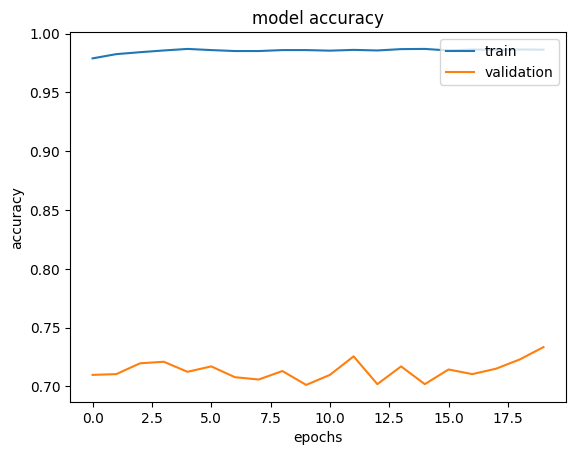

In [110]:
# summarize history for the accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show();

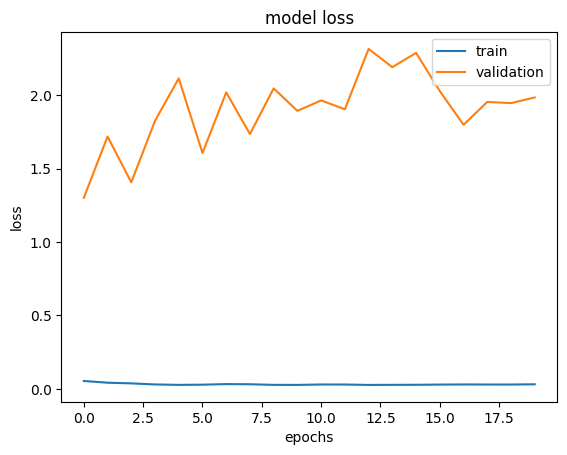

In [111]:
# summarize history for the loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Summary:
* Well that didnt go so well! We can see there is some overfitting going on. The model is clearly performing better on the training data then on the validation data and is thus not able to generalize on the test data it has not seen before. We will need to tune the hyperparams. Also, this does show us how LSTMs are not great models for NLP classification tasks due to vanishing gradients.

## Predictions

In [112]:
print(train_sents[10:20])

print(train_labels[10:20])
print(predictions[10:20])

['three people died heat wave far'
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding'
 'raining flooding florida tampabay tampa 18 19 days ive lost count'
 'flood bago myanmar arrived bago'
 'damage school bus 80 multi car crash breaking' 'whats man' 'love fruits'
 'summer lovely' 'car fast' 'goooooooaaaaaal']
[1 1 1 1 1 0 0 0 0 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


Summary:
* While the model metrics did not look great, we can see the predictions were actually spot on and correctly classified the tweets above as "Disaster" (1) vs. non-disaster (0).